# LightAutoML Baselines - Rossmann Store Sales

В этом ноутбуке мы рассмотрим создание нескольких бейзлайнов с использованием LightAutoML (LAMA) для задачи регрессии (прогнозирование продаж).

**Особенности реализации:**
- Используем данные в "первозданном виде" (без ручной генерации признаков).
- Не делаем явный сплит (используем кросс-валидацию).
- Учитываем временную структуру данных (TimeSeriesSplit).
- Проверяем целостность данных (Store IDs).

In [ ]:
import pandas as pd
import numpy as np
import logging
import sys
import matplotlib.pyplot as plt

# Logging setup
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# LightAutoML imports
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report import ReportDeco
from lightautoml.transformers.base import LAMLTransformer, SequentialTransformer, UnionTransformer, ColumnsSelector
from lightautoml.transformers.numeric import QuantileTransformer, StandardScaler
from lightautoml.transformers.categorical import LabelEncoder
from lightautoml.dataset.roles import NumericRole, CategoryRole
from lightautoml.dataset.np_pd_dataset import PandasDataset
from lightautoml.dataset.roles import DatetimeRole, CategoryRole, NumericRole
from lightautoml.addons.autots.base import AutoTS

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

RANDOM_STATE = 42

## 1. Подготовка данных
Загружаем данные, проверяем соответствие магазинов и объединяем таблицы.

In [119]:
def load_and_process_data(data_dir='data', val_size=0.05):
    train = pd.read_csv(f'{data_dir}/train.csv', dtype={'StateHoliday': str})
    test = pd.read_csv(f'{data_dir}/test.csv', dtype={'StateHoliday': str})
    store = pd.read_csv(f'{data_dir}/store.csv')
    
    train_merged = train.merge(store, on='Store', how='left')
    test_merged = test.merge(store, on='Store', how='left')
    
    train_merged['Date'] = pd.to_datetime(train_merged['Date'])
    test_merged['Date'] = pd.to_datetime(test_merged['Date'])
    
    # Фильтр: только открытые магазины
    train_merged = train_merged[train_merged['Open'] == 1].sort_values('Date').reset_index(drop=True)
    
    # Сохрани маску закрытых в test
    test_closed_mask = test_merged['Open'] == 0
    
    # Дроп колонок
    drop_cols = ['Open', 'DayOfWeek', 'Customers']
    train_merged = train_merged.drop(columns=drop_cols)
    test_merged = test_merged.drop(columns=[c for c in drop_cols if c in test_merged.columns])
    
    # Разделение по дате
    split_date = train_merged['Date'].iloc[int(len(train_merged) * (1 - val_size))]
    train_final = train_merged[train_merged['Date'] < split_date].reset_index(drop=True)
    val_final = train_merged[train_merged['Date'] >= split_date].reset_index(drop=True)

    # Проверим наличие всех магазинов в train и val
    stores_train = set(train_final['Store'].unique())
    stores_val = set(val_final['Store'].unique())
    print(f"Магазинов только в train: {len(stores_train - stores_val)}")
    print(f"Магазинов только в val: {len(stores_val - stores_train)}")
    
    return train_merged, train_final, val_final, test_merged, test_closed_mask

train_full, train, val, test, test_closed_mask = load_and_process_data()
print(f"Train full: {train_full.shape}, Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")

Магазинов только в train: 0
Магазинов только в val: 0
Train full: (844392, 15), Train: (801882, 15), Val: (42510, 15), Test: (41088, 15)


In [120]:
train

,Store,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1097,2013-01-01,5961,0,a,1,b,b,720.0,3.0,2002.0,0,NaN,NaN,NaN
1,85,2013-01-01,4220,0,a,1,b,a,1870.0,10.0,2011.0,0,NaN,NaN,NaN
2,259,2013-01-01,6851,0,a,1,b,b,210.0,NaN,NaN,0,NaN,NaN,NaN
3,262,2013-01-01,17267,0,a,1,b,a,1180.0,5.0,2013.0,0,NaN,NaN,NaN
4,274,2013-01-01,3102,0,a,1,b,b,3640.0,NaN,NaN,1,10.0,2013.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801877,745,2015-06-17,8962,1,0,0,a,a,17650.0,11.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
801878,746,2015-06-17,8038,1,0,0,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec"
801879,747,2015-06-17,8213,1,0,0,c,c,45740.0,8.0,2008.0,0,NaN,NaN,NaN
801880,748,2015-06-17,6410,1,0,0,d,a,2380.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


Из eda мы выяснили что при Open=0 продаж нет, что логично. Теперь оставим только открытые магазины в датасете и удалим признак Open. \
Для теста мы не можем просто удалить строки где Open=0, так что создадим маску для открытых магазинов и также признак Open. \
Интересный факт: у нас в train есть 54 записи, где нулевые продажи и Open=1. \
Также видим, что множества магазинов из test и train полностью совпадают!

## Настройка бейзлайна LAMA

In [70]:
TARGET_COLUMN = "Sales"
DATE_COLUMN = "Date"
ID_COLUMN = "Store"

univariate_roles = {
    "target": TARGET_COLUMN,
    DatetimeRole(seasonality=('d', 'm', 'wd'), base_date=True): DATE_COLUMN,
}

global_modelling_roles = {
    'target': TARGET_COLUMN,
    DatetimeRole(seasonality=['d', 'm', 'wd'], base_date=True): DATE_COLUMN,
    'id': ID_COLUMN,
    NumericRole(dtype=int): ['Promo', 'SchoolHoliday', 'Promo2'],
    CategoryRole(dtype=str): ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'],
    NumericRole(dtype=float): ['CompetitionDistance', 'CompetitionOpenSinceMonth', 
                                'CompetitionOpenSinceYear', 'Promo2SinceWeek', 
                                'Promo2SinceYear']
}

task = Task(
    "multi:reg",
    greater_is_better=False,
    metric="mae",
    loss="mae"
)

seq_params = {
    "seq0": {
        "case": "next_values",                  
        "params": {
            "n_target": 1,                
            "history": 1,                            
            "step": 1, 
            "from_last": True,
            "test_last": True
        }
    }
}

transformers_params = {
    "lag_features": 1,
    "lag_time_features": 1,
    "diff_features": [1,],
}

automl = AutoTS(
    task,
    reader_params = {
        "seq_params": seq_params,
    },
    time_series_trend_params={
        "trend": False,
    },
    #time_series_pipeline_params=transformers_params
)

# # Time Series Split for Validation
# n_folds = 5
# cv = TimeSeriesSplit(n_splits=n_folds)
# cv_iter = list(cv.split(train))

multi:reg isn`t supported in lgb
[03:29:18] CatBoost supports only MultiRMSE metric and loss for multi:reg task.
INFO2:lightautoml.tasks.losses.cb:CatBoost supports only MultiRMSE metric and loss for multi:reg task.
multi:reg isn`t supported in xgb


In [71]:
train["id_2"] = train[ID_COLUMN]
oof_pred_seq = automl.fit_predict(train, roles=global_modelling_roles, verbose=4)
seq_test = automl.predict(train, return_raw=True)

[03:29:31] Stdout logging level is DEBUG.
INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.
[03:29:31] Task: multi:reg

INFO:lightautoml.automl.presets.base:Task: multi:reg

[03:29:31] Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
[03:29:31] - time: 3600.00 seconds
INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds
[03:29:31] - CPU: 4 cores
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
[03:29:31] - memory: 16 GB

INFO:lightautoml.automl.presets.base:- memory: 16 GB

[03:29:31] Layer 1 train process start. Time left 3599.73 secs
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3599.73 secs
[03:29:46] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[03:29:46] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 0.75, 'max_leaf_nodes': None, 'max

/Users/andrejustinov/Desktop/AutoML/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[03:31:27] Score for RF model: -1399.940003
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -1399.940003
[03:31:27] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====


/Users/andrejustinov/Desktop/AutoML/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[03:33:19] Score for RF model: -1418.478108
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -1418.478108
[03:33:19] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -1409.2090555009702
INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -1409.2090555009702
[03:33:19] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
[03:33:19] Time left 3371.54 secs

INFO:lightautoml.automl.base:Time left 3371.54 secs

[03:33:34] Start fitting Lvl_0_Pipe_1_Mod_0_LinearL2 ...
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LinearL2 ...
[03:33:34] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 23}
DEBUG:lightautoml.ml_algo.base:Tra

In [84]:
val_pred = automl.predict(train, return_raw=True)

first_val_date = val[DATE_COLUMN].min()
freq = pd.infer_freq(train[DATE_COLUMN].iloc[:10])

n_ids = len(val_pred.id)
horizon = val_pred.data.shape[1]

res_df = pd.DataFrame({
    ID_COLUMN: np.repeat(val_pred.id, horizon),
    DATE_COLUMN: [first_val_date + pd.Timedelta(i, unit=freq) for i in range(horizon)] * n_ids,
    "pred": val_pred.data.ravel()
}).merge(val, on=[ID_COLUMN, DATE_COLUMN])

print(f"Размер после merge: {len(res_df)}")
rmspe = np.sqrt((((res_df[TARGET_COLUMN] - res_df.pred) / res_df[TARGET_COLUMN]) ** 2).mean())
print(f"RMSPE: {rmspe:.4f}")

Размер после merge: 898
RMSPE: 0.4306


In [85]:
first_val_date = val[DATE_COLUMN].min()
last_train_date = train[DATE_COLUMN].max()

# Создать полный диапазон дат с NaN для пропусков
full_range = pd.date_range(train[DATE_COLUMN].min(), last_train_date, freq='D')
all_ids = train[ID_COLUMN].unique()

full_data = pd.DataFrame({
    DATE_COLUMN: np.tile(full_range, len(all_ids)),
    ID_COLUMN: np.repeat(all_ids, len(full_range))
}).merge(train, on=[DATE_COLUMN, ID_COLUMN], how='left')

val_pred = automl.predict(full_data, return_raw=True)

n_ids = len(val_pred.id)
horizon = val_pred.data.shape[1]

res_df = pd.DataFrame({
    ID_COLUMN: np.repeat(val_pred.id, horizon),
    DATE_COLUMN: [first_val_date + pd.Timedelta(i, unit='D') for i in range(horizon)] * n_ids,
    "pred": val_pred.data.ravel()
}).merge(val, on=[ID_COLUMN, DATE_COLUMN])

rmspe = np.sqrt((((res_df[TARGET_COLUMN] - res_df.pred) / res_df[TARGET_COLUMN]) ** 2).mean())
print(f"RMSPE: {rmspe:.4f}")

RMSPE: 0.4557


<Axes: xlabel='Date'>

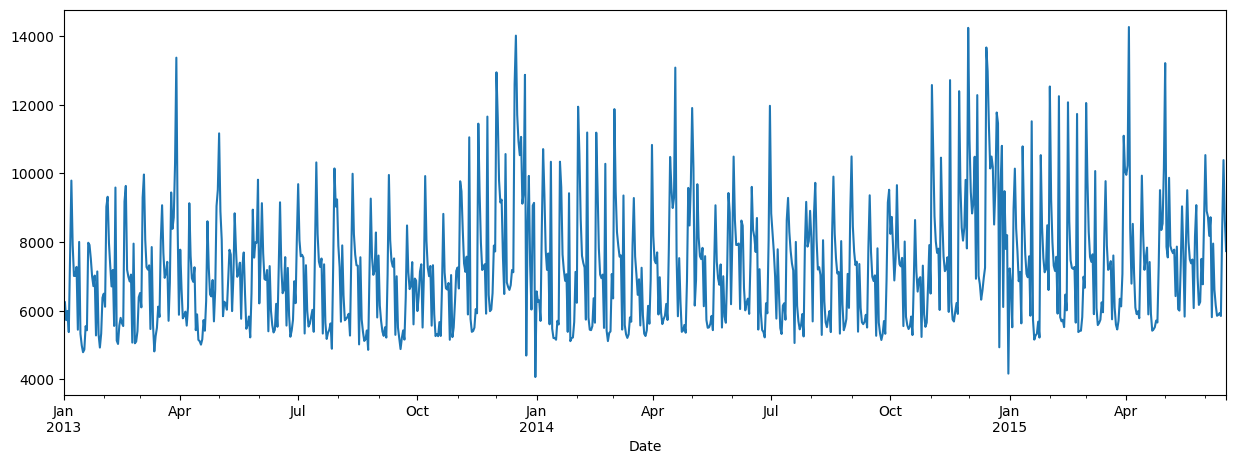

In [93]:
train.groupby('Date')['Sales'].mean().plot(figsize=(15, 5))

## LAMA Baseline

In [ ]:
# Numeric transformers
from lightautoml.transformers.numeric import (
    NaNFlags,
    FillnaMedian, 
    FillnaMean,
    FillInf,
    LogOdds,
    StandardScaler,
    QuantileBinning,
    QuantileTransformer
)

# Base transformers
from lightautoml.transformers.base import (
    LAMLTransformer,
    SequentialTransformer,
    UnionTransformer,
    ColumnsSelector,
    ColumnwiseUnion,
    ChangeRoles,
    ConvertDataset
)

# Decomposition
from lightautoml.transformers.decomposition import (
    PCATransformer,
    SVDTransformer
)

# GroupBy
from lightautoml.transformers.groupby import GroupByTransformer

# Sequential (для временных рядов)
from lightautoml.transformers.seq import (
    SeqLagTransformer,
    SeqDiffTransformer,
    SeqNumCountsTransformer,
    SeqStatisticsTransformer
)

from lightautoml.dataset.roles import (
    NumericRole,
    CategoryRole,
    DatetimeRole,
    DropRole,
    FoldsRole,
    GroupRole,
    TargetRole,
    WeightsRole,
    TreatmentRole,
    IdRole
)

from lightautoml.automl.base import AutoML
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.tuning.optuna import OptunaTuner

# Бустинг
boosting_pipe = SequentialTransformer([
    UnionTransformer([
        SequentialTransformer([
            ColumnsSelector(['CompetitionDistance', 'CompetitionOpenSinceMonth', 
                           'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']),
            NaNFlags(),
            FillnaMedian()
        ]),
        SequentialTransformer([
            ColumnsSelector(['Store', 'Sales', 'CompetitionDistance']),
            GroupByTransformer(
                group_col='Store',
                numeric_cols=['Sales', 'CompetitionDistance'],
                categorical_cols=[],
                used_transforms=['delta_mean', 'delta_median', 'std']
            )
        ])
    ])
])

In [61]:
train.to_csv('example_train.csv')

[02:15:17] Train data shape: (801882, 16)

INFO:lightautoml.reader.base:Train data shape: (801882, 16)



TypeError: 'CategoryRole' object is not iterable

In [ ]:
train_dataset = PandasDataset(data=train, roles=roles)
boosting_pipe.fit_transform(train_dataset)

/Users/andrejustinov/Desktop/AutoML/.venv/lib/python3.12/site-packages/lightautoml/transformers/groupby.py:185: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/Users/andrejustinov/Desktop/AutoML/.venv/lib/python3.12/site-packages/lightautoml/transformers/groupby.py:181: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(vals)
/Users/andrejustinov/Desktop/AutoML/.venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
automl_fast = TabularAutoML(
    task=task,
    timeout=10000,
    cpu_limit=1,
    reader_params={'cv': n_folds, 'random_state': 42}
)

automl_reported = rd(automl_fast)

# Передаем cv_iter=cv. LAMA будет использовать этот итератор для разбиения.
# Так как данные отсортированы по дате, это обеспечит корректную валидацию на будущем.
oof_pred_fast = automl_reported.fit_predict(train_data, roles=roles, cv_iter=cv_iter, verbose=1)

[14:28:34] Stdout logging level is INFO.
[14:28:34] Task: reg

[14:28:34] Start automl preset with listed constraints:
[14:28:34] - time: 10000.00 seconds
[14:28:34] - CPU: 1 cores
[14:28:34] - memory: 16 GB

[14:28:34] Train data shape: (674844, 18)

[14:28:35] Layer 1 train process start. Time left 9999.06 secs
[14:28:42] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:29:03] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2370262.0
[14:29:03] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:29:03] Time left 9971.45 secs

[14:29:21] Selector_LightGBM fitting and predicting completed
[14:29:29] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[14:30:28] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1945691.5
[14:30:28] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[14:30:28] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-21912d5c-4fb6-4ae0-9e7c-6bf03844e84e
INFO:optuna.study.study:Trial 0 finished with value: -1758666.0 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -1758666.0.


Optimization Progress:   1%|          | 1/101 [00:02<04:54,  2.94s/it, best_trial=0, best_value=-1.76e+6]

INFO:optuna.study.study:Trial 1 finished with value: -1746659.875 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -1746659.875.


Optimization Progress:   2%|▏         | 2/101 [00:05<04:52,  2.96s/it, best_trial=1, best_value=-1.75e+6]

INFO:optuna.study.study:Trial 2 finished with value: -1705833.25 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 2 with value: -1705833.25.


Optimization Progress:   3%|▎         | 3/101 [00:07<04:03,  2.49s/it, best_trial=2, best_value=-1.71e+6]

INFO:optuna.study.study:Trial 3 finished with value: -1825505.0 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 2 with value: -1705833.25.


Optimization Progress:   4%|▍         | 4/101 [00:09<03:44,  2.31s/it, best_trial=2, best_value=-1.71e+6]

INFO:optuna.study.study:Trial 4 finished with value: -1754994.75 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 2 with value: -1705833.25.


Optimization Progress:   5%|▍         | 5/101 [00:12<04:03,  2.53s/it, best_trial=2, best_value=-1.71e+6]

INFO:optuna.study.study:Trial 5 finished with value: -1756014.5 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 2 with value: -1705833.25.


Optimization Progress:   6%|▌         | 6/101 [00:14<03:38,  2.30s/it, best_trial=2, best_value=-1.71e+6]

INFO:optuna.study.study:Trial 6 finished with value: -1816444.625 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 2 with value: -1705833.25.


Optimization Progress:   7%|▋         | 7/101 [00:16<03:14,  2.07s/it, best_trial=2, best_value=-1.71e+6]

INFO:optuna.study.study:Trial 7 finished with value: -1750488.5 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 2 with value: -1705833.25.


Optimization Progress:   8%|▊         | 8/101 [00:19<03:39,  2.36s/it, best_trial=2, best_value=-1.71e+6]

INFO:optuna.study.study:Trial 8 finished with value: -1791552.625 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 2 with value: -1705833.25.


Optimization Progress:   9%|▉         | 9/101 [00:21<03:21,  2.19s/it, best_trial=2, best_value=-1.71e+6]

INFO:optuna.study.study:Trial 9 finished with value: -1655748.875 and parameters: {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  10%|▉         | 10/101 [00:24<03:50,  2.53s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 10 finished with value: -1663620.0 and parameters: {'feature_fraction': 0.9767330701904702, 'num_leaves': 151, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.0011799062523159282, 'reg_alpha': 0.005417868215013358, 'reg_lambda': 4.028557496519055e-06}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  11%|█         | 11/101 [00:27<03:54,  2.60s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 11 finished with value: -1661898.0 and parameters: {'feature_fraction': 0.9908202813290095, 'num_leaves': 165, 'bagging_fraction': 0.6899314844596016, 'min_sum_hessian_in_leaf': 0.0010353204153309649, 'reg_alpha': 0.010773441072609267, 'reg_lambda': 2.733343685812187e-06}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  12%|█▏        | 12/101 [00:29<03:59,  2.69s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 12 finished with value: -1687616.125 and parameters: {'feature_fraction': 0.8696952989083665, 'num_leaves': 168, 'bagging_fraction': 0.731319015565433, 'min_sum_hessian_in_leaf': 0.01875620628228739, 'reg_alpha': 0.06744491743341093, 'reg_lambda': 3.451025921555677e-06}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  13%|█▎        | 13/101 [00:32<03:54,  2.67s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 13 finished with value: -1685651.5 and parameters: {'feature_fraction': 0.9743589420680044, 'num_leaves': 109, 'bagging_fraction': 0.5315545010655862, 'min_sum_hessian_in_leaf': 0.0010640864803803845, 'reg_alpha': 0.0001653282123997987, 'reg_lambda': 0.012341345845574348}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  14%|█▍        | 14/101 [00:35<03:46,  2.61s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 14 finished with value: -1667651.0 and parameters: {'feature_fraction': 0.85058129769688, 'num_leaves': 186, 'bagging_fraction': 0.6710016483643558, 'min_sum_hessian_in_leaf': 0.008101324842116031, 'reg_alpha': 0.16774695769164288, 'reg_lambda': 2.1809145253208772e-07}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  15%|█▍        | 15/101 [00:37<03:50,  2.68s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 15 finished with value: -1678030.125 and parameters: {'feature_fraction': 0.9159986732442499, 'num_leaves': 125, 'bagging_fraction': 0.5127747474052716, 'min_sum_hessian_in_leaf': 0.022701605786719547, 'reg_alpha': 0.00011824786876500363, 'reg_lambda': 3.555227492360978e-05}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  16%|█▌        | 16/101 [00:40<03:51,  2.72s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 16 finished with value: -1701441.25 and parameters: {'feature_fraction': 0.5972962893353766, 'num_leaves': 198, 'bagging_fraction': 0.731057379200564, 'min_sum_hessian_in_leaf': 0.003287450666617605, 'reg_alpha': 0.03222182500619568, 'reg_lambda': 3.7927524296406806e-07}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  17%|█▋        | 17/101 [00:43<03:47,  2.71s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 17 finished with value: -1668019.625 and parameters: {'feature_fraction': 0.8570231682177613, 'num_leaves': 252, 'bagging_fraction': 0.910236126593346, 'min_sum_hessian_in_leaf': 0.018084585097830362, 'reg_alpha': 0.001644729360490525, 'reg_lambda': 1.1587196602544812e-08}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  18%|█▊        | 18/101 [00:46<03:53,  2.81s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 18 finished with value: -1745891.5 and parameters: {'feature_fraction': 0.7950108960389428, 'num_leaves': 169, 'bagging_fraction': 0.6602381051770723, 'min_sum_hessian_in_leaf': 0.0022712409222043913, 'reg_alpha': 3.35515002644197e-05, 'reg_lambda': 0.0077196214438293755}. Best is trial 9 with value: -1655748.875.


Optimization Progress:  19%|█▉        | 19/101 [00:49<03:47,  2.77s/it, best_trial=9, best_value=-1.66e+6]

INFO:optuna.study.study:Trial 19 finished with value: -1647857.75 and parameters: {'feature_fraction': 0.9153196535758042, 'num_leaves': 214, 'bagging_fraction': 0.5522204122505887, 'min_sum_hessian_in_leaf': 0.011433721178263254, 'reg_alpha': 0.3671425546987813, 'reg_lambda': 2.720645833958706e-06}. Best is trial 19 with value: -1647857.75.


Optimization Progress:  20%|█▉        | 20/101 [00:52<04:00,  2.97s/it, best_trial=19, best_value=-1.65e+6]

INFO:optuna.study.study:Trial 20 finished with value: -1643999.25 and parameters: {'feature_fraction': 0.8892010016495007, 'num_leaves': 213, 'bagging_fraction': 0.5852182314136117, 'min_sum_hessian_in_leaf': 0.0532638078343613, 'reg_alpha': 0.6849391813640964, 'reg_lambda': 4.92028755134041e-05}. Best is trial 20 with value: -1643999.25.


Optimization Progress:  21%|██        | 21/101 [00:55<04:06,  3.08s/it, best_trial=20, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 21 finished with value: -1641172.0 and parameters: {'feature_fraction': 0.9056647735773959, 'num_leaves': 218, 'bagging_fraction': 0.5671100396640618, 'min_sum_hessian_in_leaf': 0.04878691267378669, 'reg_alpha': 0.6450764748574636, 'reg_lambda': 7.181175677858407e-05}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  22%|██▏       | 22/101 [00:59<04:13,  3.20s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 22 finished with value: -1643120.75 and parameters: {'feature_fraction': 0.9223932350946185, 'num_leaves': 208, 'bagging_fraction': 0.5822982986179864, 'min_sum_hessian_in_leaf': 0.058314125858576864, 'reg_alpha': 0.6118745226794142, 'reg_lambda': 0.0001203940517905315}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  23%|██▎       | 23/101 [01:02<04:12,  3.24s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 23 finished with value: -1657848.625 and parameters: {'feature_fraction': 0.9357145447232279, 'num_leaves': 187, 'bagging_fraction': 0.5995951789866532, 'min_sum_hessian_in_leaf': 0.06244680874872217, 'reg_alpha': 0.8956049830962898, 'reg_lambda': 0.002494997669454992}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  24%|██▍       | 24/101 [01:05<04:03,  3.17s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 24 finished with value: -1667815.75 and parameters: {'feature_fraction': 0.8803609155918468, 'num_leaves': 218, 'bagging_fraction': 0.5722784806710463, 'min_sum_hessian_in_leaf': 0.1466991157913202, 'reg_alpha': 9.785700201846483, 'reg_lambda': 9.117029605568205e-05}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  25%|██▍       | 25/101 [01:09<04:06,  3.24s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 25 finished with value: -1691753.0 and parameters: {'feature_fraction': 0.826976728311899, 'num_leaves': 140, 'bagging_fraction': 0.6407856922210788, 'min_sum_hessian_in_leaf': 0.0444692677189867, 'reg_alpha': 0.9745036420783281, 'reg_lambda': 0.049226309941907735}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  26%|██▌       | 26/101 [01:11<03:47,  3.04s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 26 finished with value: -1662026.625 and parameters: {'feature_fraction': 0.9501223724326169, 'num_leaves': 188, 'bagging_fraction': 0.5081509019672742, 'min_sum_hessian_in_leaf': 0.03471749429712753, 'reg_alpha': 0.0386591663874405, 'reg_lambda': 0.00017081041887644202}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  27%|██▋       | 27/101 [01:14<03:48,  3.09s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 27 finished with value: -1662668.0 and parameters: {'feature_fraction': 0.883185662219948, 'num_leaves': 253, 'bagging_fraction': 0.6197986287051559, 'min_sum_hessian_in_leaf': 0.22728701675309998, 'reg_alpha': 0.2708246013603615, 'reg_lambda': 0.002153262045581931}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  28%|██▊       | 28/101 [01:18<03:55,  3.23s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 28 finished with value: -1650616.0 and parameters: {'feature_fraction': 0.8293948872008855, 'num_leaves': 229, 'bagging_fraction': 0.5750737460040553, 'min_sum_hessian_in_leaf': 1.860754901508511, 'reg_alpha': 2.695419870545688, 'reg_lambda': 5.0370473044604736e-05}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  29%|██▊       | 29/101 [01:21<03:50,  3.21s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 29 finished with value: -1644594.5 and parameters: {'feature_fraction': 0.9558791998705013, 'num_leaves': 215, 'bagging_fraction': 0.7183878590723448, 'min_sum_hessian_in_leaf': 0.27566855112938476, 'reg_alpha': 0.0009441764575533933, 'reg_lambda': 4.1676961483333205e-07}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  30%|██▉       | 30/101 [01:24<03:42,  3.14s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 30 finished with value: -1674632.625 and parameters: {'feature_fraction': 0.9996467385418861, 'num_leaves': 114, 'bagging_fraction': 0.6370135229602435, 'min_sum_hessian_in_leaf': 0.09308720272285893, 'reg_alpha': 0.7386300560785901, 'reg_lambda': 0.0033523320930021324}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  31%|███       | 31/101 [01:27<03:27,  2.96s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 31 finished with value: -1650488.375 and parameters: {'feature_fraction': 0.9491565818183793, 'num_leaves': 204, 'bagging_fraction': 0.7534389545778494, 'min_sum_hessian_in_leaf': 0.2508480682377495, 'reg_alpha': 0.09609004636326607, 'reg_lambda': 4.939125959048882e-07}. Best is trial 21 with value: -1641172.0.


Optimization Progress:  32%|███▏      | 32/101 [01:30<03:24,  2.96s/it, best_trial=21, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 32 finished with value: -1639595.5 and parameters: {'feature_fraction': 0.8997673610194094, 'num_leaves': 210, 'bagging_fraction': 0.7152554941436224, 'min_sum_hessian_in_leaf': 0.43883906577277826, 'reg_alpha': 0.012032598536487788, 'reg_lambda': 1.2905900902759858e-07}. Best is trial 32 with value: -1639595.5.


Optimization Progress:  33%|███▎      | 33/101 [01:33<03:25,  3.02s/it, best_trial=32, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 33 finished with value: -1635253.375 and parameters: {'feature_fraction': 0.8998892026135177, 'num_leaves': 238, 'bagging_fraction': 0.7764025771890128, 'min_sum_hessian_in_leaf': 1.1598630173023619, 'reg_alpha': 0.009985722405105193, 'reg_lambda': 1.4572291689177879e-07}. Best is trial 33 with value: -1635253.375.


Optimization Progress:  34%|███▎      | 34/101 [01:36<03:21,  3.01s/it, best_trial=33, best_value=-1.64e+6]

INFO:optuna.study.study:Trial 34 finished with value: -1634802.875 and parameters: {'feature_fraction': 0.9035131189881201, 'num_leaves': 242, 'bagging_fraction': 0.7740821171488431, 'min_sum_hessian_in_leaf': 1.4863419894201233, 'reg_alpha': 0.009695532463258905, 'reg_lambda': 5.8552277698776525e-08}. Best is trial 34 with value: -1634802.875.


Optimization Progress:  35%|███▍      | 35/101 [01:39<03:23,  3.09s/it, best_trial=34, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 35 finished with value: -1638542.5 and parameters: {'feature_fraction': 0.8986493367399433, 'num_leaves': 242, 'bagging_fraction': 0.7827504018161986, 'min_sum_hessian_in_leaf': 2.708762224918341, 'reg_alpha': 0.010063771849096377, 'reg_lambda': 8.059342674798435e-08}. Best is trial 34 with value: -1634802.875.


Optimization Progress:  36%|███▌      | 36/101 [01:42<03:22,  3.12s/it, best_trial=34, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 36 finished with value: -1724328.625 and parameters: {'feature_fraction': 0.7527880068719619, 'num_leaves': 239, 'bagging_fraction': 0.7851023089041078, 'min_sum_hessian_in_leaf': 4.514116597074947, 'reg_alpha': 0.013924344198965039, 'reg_lambda': 6.67854207734038e-08}. Best is trial 34 with value: -1634802.875.


Optimization Progress:  37%|███▋      | 37/101 [01:45<03:16,  3.07s/it, best_trial=34, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 37 finished with value: -1741079.375 and parameters: {'feature_fraction': 0.67990548355057, 'num_leaves': 254, 'bagging_fraction': 0.8371049749227472, 'min_sum_hessian_in_leaf': 2.54661240243488, 'reg_alpha': 0.0006917307444531818, 'reg_lambda': 6.103674703028738e-08}. Best is trial 34 with value: -1634802.875.


Optimization Progress:  38%|███▊      | 38/101 [01:48<03:10,  3.03s/it, best_trial=34, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 38 finished with value: -1648638.25 and parameters: {'feature_fraction': 0.8222483948479637, 'num_leaves': 242, 'bagging_fraction': 0.780264572432358, 'min_sum_hessian_in_leaf': 0.8110663678795172, 'reg_alpha': 0.005531144349464106, 'reg_lambda': 1.2483144174961021e-08}. Best is trial 34 with value: -1634802.875.


Optimization Progress:  39%|███▊      | 39/101 [01:51<03:07,  3.03s/it, best_trial=34, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 39 finished with value: -1678581.125 and parameters: {'feature_fraction': 0.589263397010737, 'num_leaves': 227, 'bagging_fraction': 0.8986243393824815, 'min_sum_hessian_in_leaf': 3.604882830436071, 'reg_alpha': 0.0034443061055198206, 'reg_lambda': 9.264613439626203e-08}. Best is trial 34 with value: -1634802.875.


Optimization Progress:  40%|███▉      | 40/101 [01:54<02:59,  2.94s/it, best_trial=34, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 40 finished with value: -1666562.5 and parameters: {'feature_fraction': 0.8510741093513269, 'num_leaves': 232, 'bagging_fraction': 0.807731457030209, 'min_sum_hessian_in_leaf': 9.490088118167996, 'reg_alpha': 0.01572226540641968, 'reg_lambda': 9.769196349082107e-07}. Best is trial 34 with value: -1634802.875.


Optimization Progress:  41%|████      | 41/101 [01:57<02:57,  2.96s/it, best_trial=34, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 41 finished with value: -1646030.875 and parameters: {'feature_fraction': 0.9020335941910567, 'num_leaves': 223, 'bagging_fraction': 0.8364659670037057, 'min_sum_hessian_in_leaf': 0.9686757600392487, 'reg_alpha': 0.00037615024065857717, 'reg_lambda': 4.1623256000986764e-08}. Best is trial 34 with value: -1634802.875.


Optimization Progress:  42%|████▏     | 42/101 [02:00<02:53,  2.94s/it, best_trial=34, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 42 finished with value: -1631139.25 and parameters: {'feature_fraction': 0.8984248202893673, 'num_leaves': 243, 'bagging_fraction': 0.775924505389352, 'min_sum_hessian_in_leaf': 0.5265696361860415, 'reg_alpha': 0.03162378697219439, 'reg_lambda': 1.6182880274435051e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  43%|████▎     | 43/101 [02:03<02:53,  2.99s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 43 finished with value: -1638779.375 and parameters: {'feature_fraction': 0.929948232993677, 'num_leaves': 243, 'bagging_fraction': 0.7550734604321981, 'min_sum_hessian_in_leaf': 0.5199924483522518, 'reg_alpha': 0.02865726407777169, 'reg_lambda': 1.556927004096496e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  44%|████▎     | 44/101 [02:06<02:55,  3.08s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 44 finished with value: -1631463.0 and parameters: {'feature_fraction': 0.9665791843593928, 'num_leaves': 17, 'bagging_fraction': 0.7644562619201914, 'min_sum_hessian_in_leaf': 1.309500357510301, 'reg_alpha': 0.030854669820479727, 'reg_lambda': 7.976408340798246e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  45%|████▍     | 45/101 [02:07<02:21,  2.53s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 45 finished with value: -1654020.125 and parameters: {'feature_fraction': 0.9667354629154238, 'num_leaves': 23, 'bagging_fraction': 0.8697855532180842, 'min_sum_hessian_in_leaf': 1.9113433263657849, 'reg_alpha': 0.0022329725630785184, 'reg_lambda': 1.0827291475788058e-06}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  46%|████▌     | 46/101 [02:09<02:00,  2.19s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 46 finished with value: -1729333.375 and parameters: {'feature_fraction': 0.8655587780824362, 'num_leaves': 88, 'bagging_fraction': 0.8164370083778107, 'min_sum_hessian_in_leaf': 1.3856172745156654, 'reg_alpha': 0.1142356184388768, 'reg_lambda': 1.0514369631605165e-05}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  47%|████▋     | 47/101 [02:11<01:56,  2.15s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 47 finished with value: -1681817.125 and parameters: {'feature_fraction': 0.9844514973958759, 'num_leaves': 84, 'bagging_fraction': 0.7661348058536898, 'min_sum_hessian_in_leaf': 3.599807309303168, 'reg_alpha': 0.005492769544316337, 'reg_lambda': 1.7819653870832342e-08}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  48%|████▊     | 48/101 [02:13<01:53,  2.14s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 48 finished with value: -1701539.5 and parameters: {'feature_fraction': 0.773317939179148, 'num_leaves': 16, 'bagging_fraction': 0.7858596570846844, 'min_sum_hessian_in_leaf': 0.6266965875915274, 'reg_alpha': 4.788076827956042e-05, 'reg_lambda': 3.044125519293317e-08}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  49%|████▊     | 49/101 [02:14<01:36,  1.85s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 49 finished with value: -1683085.5 and parameters: {'feature_fraction': 0.9443096783813315, 'num_leaves': 43, 'bagging_fraction': 0.8656182280267897, 'min_sum_hessian_in_leaf': 6.645662137491873, 'reg_alpha': 0.06843805593054486, 'reg_lambda': 1.3066689124245772e-06}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  50%|████▉     | 50/101 [02:16<01:31,  1.79s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 50 finished with value: -1773239.5 and parameters: {'feature_fraction': 0.708712490586713, 'num_leaves': 195, 'bagging_fraction': 0.7386776152738094, 'min_sum_hessian_in_leaf': 1.1787120316087403, 'reg_alpha': 3.557496135565183e-07, 'reg_lambda': 2.4025149825179926e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  50%|█████     | 51/101 [02:19<01:43,  2.08s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 51 finished with value: -1647497.0 and parameters: {'feature_fraction': 0.935629659251669, 'num_leaves': 239, 'bagging_fraction': 0.6991875040450627, 'min_sum_hessian_in_leaf': 0.4879682212855285, 'reg_alpha': 0.03077294915218483, 'reg_lambda': 1.9880314813692043e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  51%|█████▏    | 52/101 [02:22<02:00,  2.46s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 52 finished with value: -1635616.875 and parameters: {'feature_fraction': 0.9233584755748732, 'num_leaves': 255, 'bagging_fraction': 0.7621781776965048, 'min_sum_hessian_in_leaf': 2.1802212310180575, 'reg_alpha': 0.03418732504112609, 'reg_lambda': 1.1145526632146422e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  52%|█████▏    | 53/101 [02:25<02:10,  2.71s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 53 finished with value: -1640546.375 and parameters: {'feature_fraction': 0.9609697628965377, 'num_leaves': 255, 'bagging_fraction': 0.8131871934531493, 'min_sum_hessian_in_leaf': 2.280796929678924, 'reg_alpha': 0.007253616629351108, 'reg_lambda': 7.641694472396783e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  53%|█████▎    | 54/101 [02:28<02:14,  2.87s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 54 finished with value: -1644979.875 and parameters: {'feature_fraction': 0.8406714838960899, 'num_leaves': 247, 'bagging_fraction': 0.7725019302440491, 'min_sum_hessian_in_leaf': 1.463634268087757, 'reg_alpha': 0.18623571504350772, 'reg_lambda': 3.222877841400918e-08}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  54%|█████▍    | 55/101 [02:31<02:14,  2.93s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 55 finished with value: -1660836.0 and parameters: {'feature_fraction': 0.8715602075771726, 'num_leaves': 231, 'bagging_fraction': 0.7487948856680168, 'min_sum_hessian_in_leaf': 3.4430580838511182, 'reg_alpha': 0.001472919361712332, 'reg_lambda': 8.204132446820226e-08}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  55%|█████▌    | 56/101 [02:34<02:12,  2.95s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 56 finished with value: -1672251.25 and parameters: {'feature_fraction': 0.8935577234021201, 'num_leaves': 156, 'bagging_fraction': 0.7948702892709574, 'min_sum_hessian_in_leaf': 0.8143150237372407, 'reg_alpha': 0.05500495353358184, 'reg_lambda': 7.020957472530836e-06}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  56%|█████▋    | 57/101 [02:37<02:04,  2.83s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 57 finished with value: -1644922.75 and parameters: {'feature_fraction': 0.920535711560235, 'num_leaves': 175, 'bagging_fraction': 0.7122539840695739, 'min_sum_hessian_in_leaf': 5.936330336429031, 'reg_alpha': 0.01616051893601595, 'reg_lambda': 5.5565789379059405}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  57%|█████▋    | 58/101 [02:40<02:05,  2.92s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 58 finished with value: -1691582.375 and parameters: {'feature_fraction': 0.9745139443509861, 'num_leaves': 73, 'bagging_fraction': 0.8200784673710207, 'min_sum_hessian_in_leaf': 0.35802788899594434, 'reg_alpha': 0.0034178772777839514, 'reg_lambda': 1.8186354046119404e-06}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  58%|█████▊    | 59/101 [02:42<01:50,  2.64s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 59 finished with value: -1633824.5 and parameters: {'feature_fraction': 0.9149654248232989, 'num_leaves': 246, 'bagging_fraction': 0.8545992277609586, 'min_sum_hessian_in_leaf': 2.469451615364949, 'reg_alpha': 0.0005346731647926816, 'reg_lambda': 4.326726959969112e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  59%|█████▉    | 60/101 [02:45<01:53,  2.76s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 60 finished with value: -1652155.125 and parameters: {'feature_fraction': 0.8030337971221384, 'num_leaves': 221, 'bagging_fraction': 0.8626035615262877, 'min_sum_hessian_in_leaf': 1.5954494675638888, 'reg_alpha': 0.0005067763257397191, 'reg_lambda': 4.5970229196982977e-07}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  60%|██████    | 61/101 [02:48<01:51,  2.80s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 61 finished with value: -1634191.5 and parameters: {'feature_fraction': 0.9149684979003767, 'num_leaves': 247, 'bagging_fraction': 0.9726806841103507, 'min_sum_hessian_in_leaf': 2.640305167216404, 'reg_alpha': 0.00019473818659858824, 'reg_lambda': 2.667319458294935e-08}. Best is trial 42 with value: -1631139.25.


Optimization Progress:  61%|██████▏   | 62/101 [02:51<01:50,  2.83s/it, best_trial=42, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 62 finished with value: -1629971.0 and parameters: {'feature_fraction': 0.9174661156658136, 'num_leaves': 246, 'bagging_fraction': 0.9586615836960558, 'min_sum_hessian_in_leaf': 0.9777653821315668, 'reg_alpha': 1.0705300732929209e-05, 'reg_lambda': 2.1892126334478808e-08}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  62%|██████▏   | 63/101 [02:54<01:48,  2.86s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 63 finished with value: -1658396.5 and parameters: {'feature_fraction': 0.8797073749149141, 'num_leaves': 248, 'bagging_fraction': 0.9724846096365316, 'min_sum_hessian_in_leaf': 0.9582992618987307, 'reg_alpha': 3.461966560158638e-06, 'reg_lambda': 2.0108520767484868e-08}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  63%|██████▎   | 64/101 [02:57<01:46,  2.89s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 64 finished with value: -1643308.375 and parameters: {'feature_fraction': 0.9357201598625884, 'num_leaves': 235, 'bagging_fraction': 0.9525140828768297, 'min_sum_hessian_in_leaf': 1.1519178843871891, 'reg_alpha': 3.286861002248896e-05, 'reg_lambda': 3.235152968594949e-08}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  64%|██████▍   | 65/101 [03:00<01:44,  2.92s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 65 finished with value: -1640521.625 and parameters: {'feature_fraction': 0.9042846214653657, 'num_leaves': 224, 'bagging_fraction': 0.940375433414585, 'min_sum_hessian_in_leaf': 0.7104095708973848, 'reg_alpha': 1.784547186044443e-06, 'reg_lambda': 1.1944589958022381e-08}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  65%|██████▌   | 66/101 [03:03<01:41,  2.90s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 66 finished with value: -1639992.25 and parameters: {'feature_fraction': 0.9985439360693052, 'num_leaves': 246, 'bagging_fraction': 0.9148727814173204, 'min_sum_hessian_in_leaf': 0.15704852700589472, 'reg_alpha': 0.00016331119308912926, 'reg_lambda': 3.1089883380241423e-07}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  66%|██████▋   | 67/101 [03:06<01:40,  2.95s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 67 finished with value: -1673609.125 and parameters: {'feature_fraction': 0.85948017361604, 'num_leaves': 203, 'bagging_fraction': 0.9985033627127414, 'min_sum_hessian_in_leaf': 4.712386718503468, 'reg_alpha': 1.2198731065031372e-05, 'reg_lambda': 5.157962632830609e-06}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  67%|██████▋   | 68/101 [03:08<01:34,  2.88s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 68 finished with value: -1634265.75 and parameters: {'feature_fraction': 0.9126632401033405, 'num_leaves': 233, 'bagging_fraction': 0.8873868723837799, 'min_sum_hessian_in_leaf': 0.36242263323084056, 'reg_alpha': 6.290508644474235e-05, 'reg_lambda': 1.1981472682656231}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  68%|██████▊   | 69/101 [03:12<01:34,  2.94s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 69 finished with value: -1642797.625 and parameters: {'feature_fraction': 0.9622435550621617, 'num_leaves': 231, 'bagging_fraction': 0.8896570266885971, 'min_sum_hessian_in_leaf': 0.1698356881892425, 'reg_alpha': 0.00011034410472351744, 'reg_lambda': 1.6991573995620481}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  69%|██████▉   | 70/101 [03:15<01:33,  3.02s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 70 finished with value: -1662978.125 and parameters: {'feature_fraction': 0.9118087884890688, 'num_leaves': 139, 'bagging_fraction': 0.9493372981461456, 'min_sum_hessian_in_leaf': 0.34568027294813136, 'reg_alpha': 1.109195407376426e-05, 'reg_lambda': 0.08832086501631867}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  70%|███████   | 71/101 [03:17<01:25,  2.85s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 71 finished with value: -1636828.5 and parameters: {'feature_fraction': 0.8872542827831211, 'num_leaves': 237, 'bagging_fraction': 0.9232518703380304, 'min_sum_hessian_in_leaf': 0.652543174905837, 'reg_alpha': 5.034740213766396e-05, 'reg_lambda': 1.878899375870398e-05}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  71%|███████▏  | 72/101 [03:20<01:24,  2.90s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 72 finished with value: -1638956.875 and parameters: {'feature_fraction': 0.9462817599360656, 'num_leaves': 248, 'bagging_fraction': 0.9721254007695619, 'min_sum_hessian_in_leaf': 1.5723773193948327, 'reg_alpha': 1.8463439586158126e-05, 'reg_lambda': 0.0009089786270046449}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  72%|███████▏  | 73/101 [03:23<01:21,  2.93s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 73 finished with value: -1638440.375 and parameters: {'feature_fraction': 0.9256916896691173, 'num_leaves': 224, 'bagging_fraction': 0.8496394474011226, 'min_sum_hessian_in_leaf': 2.889322156608982, 'reg_alpha': 0.00019824057259794554, 'reg_lambda': 0.46711589232220224}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  73%|███████▎  | 74/101 [03:26<01:19,  2.95s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 74 finished with value: -1636778.875 and parameters: {'feature_fraction': 0.9832897352262591, 'num_leaves': 237, 'bagging_fraction': 0.9316735603191215, 'min_sum_hessian_in_leaf': 1.1661481171210535, 'reg_alpha': 8.351842943300761e-05, 'reg_lambda': 6.463787872870313e-08}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  74%|███████▍  | 75/101 [03:29<01:18,  3.00s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 75 finished with value: -1743468.0 and parameters: {'feature_fraction': 0.5021328242984184, 'num_leaves': 247, 'bagging_fraction': 0.9708234278709641, 'min_sum_hessian_in_leaf': 0.37531541001618635, 'reg_alpha': 0.00027758067810432327, 'reg_lambda': 5.422653705707538e-07}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  75%|███████▌  | 76/101 [03:32<01:12,  2.89s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 76 finished with value: -1673525.125 and parameters: {'feature_fraction': 0.9113861246519731, 'num_leaves': 123, 'bagging_fraction': 0.8922339166462696, 'min_sum_hessian_in_leaf': 0.5815247741623903, 'reg_alpha': 0.0011227113693598975, 'reg_lambda': 1.809103091308351e-07}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  76%|███████▌  | 77/101 [03:34<01:05,  2.72s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 77 finished with value: -1664196.375 and parameters: {'feature_fraction': 0.8443646920398845, 'num_leaves': 218, 'bagging_fraction': 0.7978920366166142, 'min_sum_hessian_in_leaf': 0.8401365137905366, 'reg_alpha': 1.000542083073795e-06, 'reg_lambda': 4.7867430703615095e-08}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  77%|███████▋  | 78/101 [03:37<01:03,  2.77s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 78 finished with value: -1648892.0 and parameters: {'feature_fraction': 0.8712214447805927, 'num_leaves': 228, 'bagging_fraction': 0.8765641506814633, 'min_sum_hessian_in_leaf': 1.8214972786961252, 'reg_alpha': 0.002428649921945045, 'reg_lambda': 9.339432031864014}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  78%|███████▊  | 79/101 [03:41<01:04,  2.95s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 79 finished with value: -1683605.25 and parameters: {'feature_fraction': 0.9380990231281686, 'num_leaves': 98, 'bagging_fraction': 0.8239692665939305, 'min_sum_hessian_in_leaf': 0.9660859577425828, 'reg_alpha': 0.0007615649881478189, 'reg_lambda': 1.8527692884952835e-08}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  79%|███████▉  | 80/101 [03:43<00:57,  2.75s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 80 finished with value: -1764711.625 and parameters: {'feature_fraction': 0.6210786639348762, 'num_leaves': 210, 'bagging_fraction': 0.7372669565391888, 'min_sum_hessian_in_leaf': 2.9740519222891826, 'reg_alpha': 5.373057339787557e-06, 'reg_lambda': 2.9967213203108673e-06}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  80%|████████  | 81/101 [03:46<00:55,  2.75s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 81 finished with value: -1630713.125 and parameters: {'feature_fraction': 0.9227522585204638, 'num_leaves': 255, 'bagging_fraction': 0.7618861094958697, 'min_sum_hessian_in_leaf': 2.182395360039646, 'reg_alpha': 0.02325111920024117, 'reg_lambda': 1.4440898433537843e-07}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  81%|████████  | 82/101 [03:49<00:55,  2.89s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 82 finished with value: -1656514.75 and parameters: {'feature_fraction': 0.8811175226832989, 'num_leaves': 242, 'bagging_fraction': 0.9960687758415893, 'min_sum_hessian_in_leaf': 2.088781900879418, 'reg_alpha': 0.35398730827759284, 'reg_lambda': 1.1467316374347579e-07}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  82%|████████▏ | 83/101 [03:52<00:51,  2.88s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 83 finished with value: -1631278.0 and parameters: {'feature_fraction': 0.9566575836943243, 'num_leaves': 248, 'bagging_fraction': 0.8504817640591631, 'min_sum_hessian_in_leaf': 5.352055949197212, 'reg_alpha': 1.2881940657219034e-08, 'reg_lambda': 2.234568820681211e-07}. Best is trial 62 with value: -1629971.0.


Optimization Progress:  83%|████████▎ | 84/101 [03:55<00:50,  2.94s/it, best_trial=62, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 84 finished with value: -1627765.125 and parameters: {'feature_fraction': 0.9538802877110092, 'num_leaves': 250, 'bagging_fraction': 0.8560104020723122, 'min_sum_hessian_in_leaf': 7.673665199276011, 'reg_alpha': 1.514118379779812e-08, 'reg_lambda': 2.775975283129386e-07}. Best is trial 84 with value: -1627765.125.


Optimization Progress:  84%|████████▍ | 85/101 [03:58<00:48,  3.00s/it, best_trial=84, best_value=-1.63e+6]

INFO:optuna.study.study:Trial 85 finished with value: -1623984.75 and parameters: {'feature_fraction': 0.9675112817101049, 'num_leaves': 252, 'bagging_fraction': 0.857038115469544, 'min_sum_hessian_in_leaf': 9.66652207603663, 'reg_alpha': 2.5596240999683455e-08, 'reg_lambda': 0.017417475217309176}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  85%|████████▌ | 86/101 [04:01<00:45,  3.05s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 86 finished with value: -1638867.5 and parameters: {'feature_fraction': 0.9708308559711977, 'num_leaves': 252, 'bagging_fraction': 0.8543710793582328, 'min_sum_hessian_in_leaf': 8.982306346792262, 'reg_alpha': 1.0407718606644562e-08, 'reg_lambda': 2.899719679953207e-07}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  86%|████████▌ | 87/101 [04:04<00:43,  3.07s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 87 finished with value: -1639181.125 and parameters: {'feature_fraction': 0.9607440191695809, 'num_leaves': 250, 'bagging_fraction': 0.8307972846967685, 'min_sum_hessian_in_leaf': 7.513807175354734, 'reg_alpha': 7.420515106815959e-08, 'reg_lambda': 6.565464384505047e-07}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  87%|████████▋ | 88/101 [04:07<00:40,  3.10s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 88 finished with value: -1645614.875 and parameters: {'feature_fraction': 0.9876479285329018, 'num_leaves': 244, 'bagging_fraction': 0.8461051106985321, 'min_sum_hessian_in_leaf': 5.275997131391055, 'reg_alpha': 3.649010160192609e-08, 'reg_lambda': 1.5463405826834825e-06}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  88%|████████▊ | 89/101 [04:11<00:37,  3.11s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 89 finished with value: -1684148.25 and parameters: {'feature_fraction': 0.9537367059280044, 'num_leaves': 55, 'bagging_fraction': 0.900971360311067, 'min_sum_hessian_in_leaf': 4.56483257247248, 'reg_alpha': 2.9409741491862838e-08, 'reg_lambda': 2.082696796250336e-06}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  89%|████████▉ | 90/101 [04:12<00:29,  2.72s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 90 finished with value: -1640528.25 and parameters: {'feature_fraction': 0.976329038519187, 'num_leaves': 254, 'bagging_fraction': 0.8752392458290579, 'min_sum_hessian_in_leaf': 3.9431373346502965, 'reg_alpha': 1.7916635885420428e-07, 'reg_lambda': 0.007739036224553838}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  90%|█████████ | 91/101 [04:15<00:28,  2.84s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 91 finished with value: -1639175.5 and parameters: {'feature_fraction': 0.9431832478168485, 'num_leaves': 234, 'bagging_fraction': 0.8824001051777894, 'min_sum_hessian_in_leaf': 7.567815470223713, 'reg_alpha': 6.042134386637781e-08, 'reg_lambda': 0.045591956407520444}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  91%|█████████ | 92/101 [04:19<00:26,  2.91s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 92 finished with value: -1638805.125 and parameters: {'feature_fraction': 0.9277011195206344, 'num_leaves': 255, 'bagging_fraction': 0.9077433644406863, 'min_sum_hessian_in_leaf': 6.465122693752228, 'reg_alpha': 1.4003213512988969e-08, 'reg_lambda': 0.0004566876349305154}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  92%|█████████▏| 93/101 [04:22<00:23,  2.94s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 93 finished with value: -1628500.75 and parameters: {'feature_fraction': 0.9215689893365893, 'num_leaves': 242, 'bagging_fraction': 0.8579282578210289, 'min_sum_hessian_in_leaf': 9.738475530601287, 'reg_alpha': 2.4877757205883886e-08, 'reg_lambda': 0.024449151327315722}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  93%|█████████▎| 94/101 [04:25<00:20,  2.96s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 94 finished with value: -1635571.375 and parameters: {'feature_fraction': 0.9550479626440115, 'num_leaves': 241, 'bagging_fraction': 0.8568491136299833, 'min_sum_hessian_in_leaf': 7.329536904479234, 'reg_alpha': 2.0461100752678145e-08, 'reg_lambda': 0.08027131227295692}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  94%|█████████▍| 95/101 [04:28<00:18,  3.01s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 95 finished with value: -1638506.0 and parameters: {'feature_fraction': 0.9938778526530522, 'num_leaves': 249, 'bagging_fraction': 0.8371583703594488, 'min_sum_hessian_in_leaf': 9.508689415976395, 'reg_alpha': 5.630125077612008e-08, 'reg_lambda': 0.010076294139872143}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  95%|█████████▌| 96/101 [04:31<00:15,  3.06s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 96 finished with value: -1640952.125 and parameters: {'feature_fraction': 0.9680241421431783, 'num_leaves': 227, 'bagging_fraction': 0.7956273182074375, 'min_sum_hessian_in_leaf': 5.026037360684232, 'reg_alpha': 1.12268984087801e-07, 'reg_lambda': 0.02745763443323469}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  96%|█████████▌| 97/101 [04:34<00:12,  3.05s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 97 finished with value: -1638828.25 and parameters: {'feature_fraction': 0.9226052096030594, 'num_leaves': 245, 'bagging_fraction': 0.9209735443162257, 'min_sum_hessian_in_leaf': 3.2774076026752876, 'reg_alpha': 6.283292143162387e-07, 'reg_lambda': 0.022615261440928458}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  97%|█████████▋| 98/101 [04:37<00:09,  3.04s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 98 finished with value: -1640102.375 and parameters: {'feature_fraction': 0.9461931582326316, 'num_leaves': 238, 'bagging_fraction': 0.8041092977450376, 'min_sum_hessian_in_leaf': 3.973015856971609, 'reg_alpha': 2.0846722024368766e-08, 'reg_lambda': 2.745495664130415e-07}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  98%|█████████▊| 99/101 [04:40<00:06,  3.06s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 99 finished with value: -1640963.625 and parameters: {'feature_fraction': 0.9354010771436823, 'num_leaves': 218, 'bagging_fraction': 0.6757828891487903, 'min_sum_hessian_in_leaf': 2.511623988888227, 'reg_alpha': 1.0049814457800876e-08, 'reg_lambda': 0.16949953302415324}. Best is trial 85 with value: -1623984.75.


Optimization Progress:  99%|█████████▉| 100/101 [04:43<00:03,  3.10s/it, best_trial=85, best_value=-1.62e+6]

INFO:optuna.study.study:Trial 100 finished with value: -1638809.375 and parameters: {'feature_fraction': 0.8944486590139469, 'num_leaves': 250, 'bagging_fraction': 0.8271691434798899, 'min_sum_hessian_in_leaf': 6.120705174050448, 'reg_alpha': 4.1411637788877055e-08, 'reg_lambda': 8.510061814102742e-07}. Best is trial 85 with value: -1623984.75.


Optimization Progress: 100%|██████████| 101/101 [04:46<00:00,  2.84s/it, best_trial=85, best_value=-1.62e+6]

[14:35:15] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[14:35:15] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[14:36:08] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1914097.125
[14:36:08] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[14:36:08] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[14:39:08] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -2110780.0
[14:39:08] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[14:39:08] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c696ce11-1304-4ebe-ab7d-bf5c007af03c
INFO:optuna.study.study:Trial 0 finished with value: -1911245.5 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -1911245.5.


Optimization Progress:   1%|          | 1/101 [00:02<04:39,  2.80s/it, best_trial=0, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 1 finished with value: -1915865.0 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: -1911245.5.


Optimization Progress:   2%|▏         | 2/101 [00:05<04:21,  2.64s/it, best_trial=0, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 2 finished with value: -1907396.75 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 2 with value: -1907396.75.


Optimization Progress:   3%|▎         | 3/101 [00:07<04:14,  2.60s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 3 finished with value: -1915868.0 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 2 with value: -1907396.75.


Optimization Progress:   4%|▍         | 4/101 [00:10<04:09,  2.57s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 4 finished with value: -1934480.875 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 2 with value: -1907396.75.


Optimization Progress:   5%|▍         | 5/101 [00:13<04:33,  2.85s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 5 finished with value: -1934482.625 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 2 with value: -1907396.75.


Optimization Progress:   6%|▌         | 6/101 [00:17<04:47,  3.02s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 6 finished with value: -1942877.125 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 2 with value: -1907396.75.


Optimization Progress:   7%|▋         | 7/101 [00:20<04:55,  3.15s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 7 finished with value: -1911130.375 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 2 with value: -1907396.75.


Optimization Progress:   8%|▊         | 8/101 [00:24<05:11,  3.35s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 8 finished with value: -1911311.875 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 2 with value: -1907396.75.


Optimization Progress:   9%|▉         | 9/101 [00:26<04:45,  3.10s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 9 finished with value: -1934481.375 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  10%|▉         | 10/101 [00:30<04:49,  3.18s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 10 finished with value: -1911245.125 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1692997958212103e-08, 'min_data_in_leaf': 14}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  11%|█         | 11/101 [00:32<04:35,  3.06s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 11 finished with value: -1911155.25 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 3.5637622153645955e-07, 'min_data_in_leaf': 9}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  12%|█▏        | 12/101 [00:36<04:52,  3.28s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 12 finished with value: -1944804.625 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06544410631655989, 'min_data_in_leaf': 1}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  13%|█▎        | 13/101 [00:40<05:00,  3.41s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 13 finished with value: -1923792.125 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2932025145672363e-06, 'min_data_in_leaf': 13}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  14%|█▍        | 14/101 [00:43<04:46,  3.30s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 14 finished with value: -1911255.25 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05355323583500332, 'min_data_in_leaf': 8}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  15%|█▍        | 15/101 [00:46<04:29,  3.14s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 15 finished with value: -1923792.125 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0503935967657642e-07, 'min_data_in_leaf': 12}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  16%|█▌        | 16/101 [00:49<04:24,  3.11s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 16 finished with value: -1911155.25 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.416782110574224e-06, 'min_data_in_leaf': 6}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  17%|█▋        | 17/101 [00:53<04:38,  3.32s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 17 finished with value: -1911255.25 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05323860684070531, 'min_data_in_leaf': 17}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  18%|█▊        | 18/101 [00:55<04:21,  3.16s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 18 finished with value: -1923792.375 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00015069331870749583, 'min_data_in_leaf': 3}. Best is trial 2 with value: -1907396.75.


Optimization Progress:  19%|█▉        | 19/101 [00:58<04:15,  3.11s/it, best_trial=2, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 19 finished with value: -1907369.875 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3232715850545045, 'min_data_in_leaf': 8}. Best is trial 19 with value: -1907369.875.


Optimization Progress:  20%|█▉        | 20/101 [01:01<03:58,  2.95s/it, best_trial=19, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 20 finished with value: -1912245.75 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.474041064227797, 'min_data_in_leaf': 8}. Best is trial 19 with value: -1907369.875.


Optimization Progress:  21%|██        | 21/101 [01:04<03:46,  2.83s/it, best_trial=19, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 21 finished with value: -1907324.125 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.36284377065328205, 'min_data_in_leaf': 11}. Best is trial 21 with value: -1907324.125.


Optimization Progress:  22%|██▏       | 22/101 [01:06<03:37,  2.75s/it, best_trial=21, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 22 finished with value: -1905065.625 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.985144762358534, 'min_data_in_leaf': 11}. Best is trial 22 with value: -1905065.625.


Optimization Progress:  23%|██▎       | 23/101 [01:09<03:30,  2.70s/it, best_trial=22, best_value=-1.91e+6]

INFO:optuna.study.study:Trial 23 finished with value: -1881474.75 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.384338222634642, 'min_data_in_leaf': 11}. Best is trial 23 with value: -1881474.75.


Optimization Progress:  24%|██▍       | 24/101 [01:12<03:30,  2.74s/it, best_trial=23, best_value=-1.88e+6]

INFO:optuna.study.study:Trial 24 finished with value: -1891339.0 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.852335368950572, 'min_data_in_leaf': 11}. Best is trial 23 with value: -1881474.75.


Optimization Progress:  25%|██▍       | 25/101 [01:14<03:29,  2.76s/it, best_trial=23, best_value=-1.88e+6]

INFO:optuna.study.study:Trial 25 finished with value: -1891339.75 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.9434393332740516, 'min_data_in_leaf': 17}. Best is trial 23 with value: -1881474.75.


Optimization Progress:  26%|██▌       | 26/101 [01:17<03:27,  2.77s/it, best_trial=23, best_value=-1.88e+6]

INFO:optuna.study.study:Trial 26 finished with value: -1871800.0 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.167124079362189, 'min_data_in_leaf': 17}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  27%|██▋       | 27/101 [01:20<03:26,  2.80s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 27 finished with value: -1907015.125 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 9.937351542493216, 'min_data_in_leaf': 20}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  28%|██▊       | 28/101 [01:23<03:30,  2.89s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 28 finished with value: -1892719.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.34192802312659, 'min_data_in_leaf': 17}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  29%|██▊       | 29/101 [01:26<03:25,  2.85s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 29 finished with value: -1892517.25 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.011365978334261312, 'min_data_in_leaf': 15}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  30%|██▉       | 30/101 [01:29<03:20,  2.83s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 30 finished with value: -1892648.25 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.9050234251999908, 'min_data_in_leaf': 18}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  31%|███       | 31/101 [01:31<03:16,  2.81s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 31 finished with value: -1912639.375 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.788908954221743, 'min_data_in_leaf': 18}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  32%|███▏      | 32/101 [01:34<03:13,  2.80s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 32 finished with value: -1892832.125 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9871604014878435, 'min_data_in_leaf': 15}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  33%|███▎      | 33/101 [01:37<03:09,  2.79s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 33 finished with value: -1923913.75 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1471921136979337, 'min_data_in_leaf': 13}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  34%|███▎      | 34/101 [01:40<03:11,  2.86s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 34 finished with value: -1872201.375 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5543782441451106, 'min_data_in_leaf': 16}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  35%|███▍      | 35/101 [01:43<03:06,  2.83s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 35 finished with value: -1892538.875 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.1718360304106543, 'min_data_in_leaf': 16}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  36%|███▌      | 36/101 [01:45<03:02,  2.81s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 36 finished with value: -1916579.5 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.010967969163772438, 'min_data_in_leaf': 13}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  37%|███▋      | 37/101 [01:48<03:03,  2.87s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 37 finished with value: -1892670.25 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0423112708403701, 'min_data_in_leaf': 19}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  38%|███▊      | 38/101 [01:51<02:58,  2.84s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 38 finished with value: -1899472.625 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.904426317129389, 'min_data_in_leaf': 14}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  39%|███▊      | 39/101 [01:54<03:00,  2.91s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 39 finished with value: -1890014.0 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 3.174232312185688, 'min_data_in_leaf': 10}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  40%|███▉      | 40/101 [01:57<02:55,  2.87s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 40 finished with value: -1915862.75 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0043591590713435565, 'min_data_in_leaf': 10}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  41%|████      | 41/101 [02:00<02:46,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 41 finished with value: -1889788.75 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 3.760733336129672, 'min_data_in_leaf': 12}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  42%|████▏     | 42/101 [02:02<02:43,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 42 finished with value: -1892594.0 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5525882777916821, 'min_data_in_leaf': 12}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  43%|████▎     | 43/101 [02:05<02:40,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 43 finished with value: -1872351.0 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.2580535391630945, 'min_data_in_leaf': 9}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  44%|████▎     | 44/101 [02:08<02:37,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 44 finished with value: -1915710.25 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13811961024545277, 'min_data_in_leaf': 7}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  45%|████▍     | 45/101 [02:10<02:31,  2.70s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 45 finished with value: -1892723.125 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.363673406705279, 'min_data_in_leaf': 16}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  46%|████▌     | 46/101 [02:13<02:29,  2.72s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 46 finished with value: -1892519.75 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.031555366598771166, 'min_data_in_leaf': 9}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  47%|████▋     | 47/101 [02:16<02:27,  2.73s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 47 finished with value: -1916571.875 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0005968994109134419, 'min_data_in_leaf': 12}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  48%|████▊     | 48/101 [02:19<02:29,  2.82s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 48 finished with value: -1928383.875 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.734497438841785, 'min_data_in_leaf': 14}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  49%|████▊     | 49/101 [02:22<02:35,  2.98s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 49 finished with value: -1915596.0 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.24004769403300058, 'min_data_in_leaf': 5}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  50%|████▉     | 50/101 [02:25<02:25,  2.85s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 50 finished with value: -1914097.125 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.7610400316756569, 'min_data_in_leaf': 15}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  50%|█████     | 51/101 [02:28<02:25,  2.90s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 51 finished with value: -1872210.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5351954533854877, 'min_data_in_leaf': 10}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  51%|█████▏    | 52/101 [02:31<02:20,  2.86s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 52 finished with value: -1872220.375 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5151148498253115, 'min_data_in_leaf': 9}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  52%|█████▏    | 53/101 [02:33<02:16,  2.83s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 53 finished with value: -1892769.0 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.6305130603978217, 'min_data_in_leaf': 7}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  53%|█████▎    | 54/101 [02:36<02:12,  2.81s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 54 finished with value: -1892591.875 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5403702412012438, 'min_data_in_leaf': 9}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  54%|█████▍    | 55/101 [02:39<02:08,  2.79s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 55 finished with value: -1892515.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 4.0272705572720885e-05, 'min_data_in_leaf': 7}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  55%|█████▌    | 56/101 [02:42<02:05,  2.78s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 56 finished with value: -1915789.75 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.06819479638820439, 'min_data_in_leaf': 8}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  56%|█████▋    | 57/101 [02:44<01:59,  2.71s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 57 finished with value: -1892831.5 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9846917640881807, 'min_data_in_leaf': 10}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  57%|█████▋    | 58/101 [02:47<01:57,  2.72s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 58 finished with value: -1907348.5 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 9.650554673574444, 'min_data_in_leaf': 9}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  58%|█████▊    | 59/101 [02:50<01:59,  2.84s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 59 finished with value: -1883173.875 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.32395573660315, 'min_data_in_leaf': 3}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  59%|█████▉    | 60/101 [02:53<01:53,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 60 finished with value: -1892556.125 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.292427594908636, 'min_data_in_leaf': 11}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  60%|██████    | 61/101 [02:56<01:50,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 61 finished with value: -1883159.125 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.336650491195194, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  61%|██████▏   | 62/101 [02:58<01:45,  2.71s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 62 finished with value: -1892471.25 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5180033517718243, 'min_data_in_leaf': 5}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  62%|██████▏   | 63/101 [03:01<01:41,  2.67s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 63 finished with value: -1914047.125 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.7666493085216136, 'min_data_in_leaf': 3}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  63%|██████▎   | 64/101 [03:03<01:37,  2.63s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 64 finished with value: -1894566.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 3.9709317923694814, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  64%|██████▍   | 65/101 [03:06<01:35,  2.67s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 65 finished with value: -1894355.25 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 5.406762881395928, 'min_data_in_leaf': 18}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  65%|██████▌   | 66/101 [03:09<01:34,  2.69s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 66 finished with value: -1892515.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 5.8407967333666245e-08, 'min_data_in_leaf': 19}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  66%|██████▋   | 67/101 [03:11<01:32,  2.71s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 67 finished with value: -1913163.875 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.2925679961303564, 'min_data_in_leaf': 16}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  67%|██████▋   | 68/101 [03:14<01:32,  2.80s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 68 finished with value: -1955543.0 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.9787908256536045e-06, 'min_data_in_leaf': 6}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  68%|██████▊   | 69/101 [03:18<01:34,  2.96s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 69 finished with value: -1915766.375 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0885481162821977, 'min_data_in_leaf': 8}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  69%|██████▉   | 70/101 [03:20<01:27,  2.83s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 70 finished with value: -1911250.5 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02893300728776851, 'min_data_in_leaf': 10}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  70%|███████   | 71/101 [03:23<01:24,  2.81s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 71 finished with value: -1881702.75 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.68397226099778, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  71%|███████▏  | 72/101 [03:26<01:19,  2.74s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 72 finished with value: -1881522.625 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.8657275946606875, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  72%|███████▏  | 73/101 [03:28<01:15,  2.69s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 73 finished with value: -1878580.125 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.057834000147894, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  73%|███████▎  | 74/101 [03:31<01:11,  2.65s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 74 finished with value: -1907708.5 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.573396721465736, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  74%|███████▍  | 75/101 [03:33<01:07,  2.61s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 75 finished with value: -1872313.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.328780160677733, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  75%|███████▌  | 76/101 [03:36<01:06,  2.65s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 76 finished with value: -1872192.25 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5733878312154648, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  76%|███████▌  | 77/101 [03:39<01:04,  2.68s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 77 finished with value: -1892826.75 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9576357279903103, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  77%|███████▋  | 78/101 [03:42<01:02,  2.71s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 78 finished with value: -1892566.25 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.36580742364102026, 'min_data_in_leaf': 4}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  78%|███████▊  | 79/101 [03:44<00:59,  2.72s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 79 finished with value: -1892603.75 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6183770374508986, 'min_data_in_leaf': 3}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  79%|███████▉  | 80/101 [03:47<00:57,  2.73s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 80 finished with value: -1902231.125 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5547306774508813, 'min_data_in_leaf': 4}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  80%|████████  | 81/101 [03:50<00:56,  2.83s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 81 finished with value: -1892655.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.9515899232591896, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  81%|████████  | 82/101 [03:53<00:53,  2.81s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 82 finished with value: -1899552.25 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.1187281818772394, 'min_data_in_leaf': 5}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  82%|████████▏ | 83/101 [03:56<00:50,  2.80s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 83 finished with value: -1892708.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.2754682229874292, 'min_data_in_leaf': 17}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  83%|████████▎ | 84/101 [03:58<00:47,  2.78s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 84 finished with value: -1889922.125 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 3.3974226710462707, 'min_data_in_leaf': 19}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  84%|████████▍ | 85/101 [04:01<00:44,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 85 finished with value: -1892826.0 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9524847652055857, 'min_data_in_leaf': 11}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  85%|████████▌ | 86/101 [04:04<00:41,  2.78s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 86 finished with value: -1911287.0 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2173858494596672, 'min_data_in_leaf': 12}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  86%|████████▌ | 87/101 [04:07<00:38,  2.78s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 87 finished with value: -1892587.75 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.510629526028667, 'min_data_in_leaf': 9}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  87%|████████▋ | 88/101 [04:10<00:35,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 88 finished with value: -1892724.625 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3707498442214257, 'min_data_in_leaf': 14}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  88%|████████▊ | 89/101 [04:12<00:33,  2.76s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 89 finished with value: -1892515.75 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00016139896275157282, 'min_data_in_leaf': 13}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  89%|████████▉ | 90/101 [04:15<00:30,  2.76s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 90 finished with value: -1929226.125 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.393557254221232, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  90%|█████████ | 91/101 [04:18<00:28,  2.85s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 91 finished with value: -1879660.25 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.35401338367202, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  91%|█████████ | 92/101 [04:21<00:24,  2.77s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 92 finished with value: -1879788.375 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.223812320465986, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  92%|█████████▏| 93/101 [04:23<00:21,  2.71s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 93 finished with value: -1901788.25 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.848036134702092, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  93%|█████████▎| 94/101 [04:26<00:18,  2.66s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 94 finished with value: -1912779.375 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.0935745077064074, 'min_data_in_leaf': 3}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  94%|█████████▍| 95/101 [04:28<00:15,  2.62s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 95 finished with value: -1891500.0 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.0786904371195902, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  95%|█████████▌| 96/101 [04:31<00:13,  2.61s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 96 finished with value: -1913963.375 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.8468236335886125, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  96%|█████████▌| 97/101 [04:33<00:10,  2.58s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 97 finished with value: -1883193.5 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.307254545356677, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  97%|█████████▋| 98/101 [04:36<00:07,  2.61s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 98 finished with value: -1915865.625 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018159356518508871, 'min_data_in_leaf': 2}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  98%|█████████▊| 99/101 [04:39<00:05,  2.61s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 99 finished with value: -1915412.0 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.4074056344190808, 'min_data_in_leaf': 3}. Best is trial 26 with value: -1871800.0.


Optimization Progress:  99%|█████████▉| 100/101 [04:41<00:02,  2.60s/it, best_trial=26, best_value=-1.87e+6]

INFO:optuna.study.study:Trial 100 finished with value: -1871831.375 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.111686218113018, 'min_data_in_leaf': 1}. Best is trial 26 with value: -1871800.0.


Optimization Progress: 100%|██████████| 101/101 [04:44<00:00,  2.82s/it, best_trial=26, best_value=-1.87e+6]

[14:43:52] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[14:43:52] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[14:46:09] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -2190724.25
[14:46:09] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[14:46:09] Time left 8945.48 secs

[14:46:09] Layer 1 training completed.

[14:46:09] Blending: optimization starts with equal weights. Score = -1937210.7500000
[14:46:09] Blending: iteration 0: score = -1900068.3750000, weights = [0.         0.22523865 0.56189543 0.10297609 0.10988986]
[14:46:09] Blending: iteration 1: score = -1877564.2500000, weights = [0.13000274 0.05743735 0.7296039  0.         0.08295603]
[14:46:09] Blending: iteration 2: score = -1874447.1250000, weights = [0.1773768  0.         0.76612157 0.         0.05650163]
[14:46:10] Blending: iteration 3: score = -1874231.8750000, weights = [0.1911324  0.         0.75426215 0.         0.05460551]
[14:46:10] Blending: iteration 4: score = -1874152.3750000, weights = [0.22103201 0.         0.778968   0.         0.        ]
[14:46:10] Blending: best score = -1874152.

In [80]:
train_lama = automl_fast.reader.read(train_data)
val_lama = automl_fast.reader.read(val_data)
pipeline = automl_fast.get_feature_pipeline("gbm")

train_feats = pipeline.fit_transform(train_lama)
val_feats = pipeline.transform(val_lama)

val_processed_df = pd.DataFrame(val_feats.data, columns=val_feats.features)

In [86]:
val_processed_df

,freq__Assortment,freq__PromoInterval,le__DayOfWeek,le__Promo2SinceYear,inter__(Store__CompetitionDistance),inter__(Store__Promo2SinceWeek),inter__(Store__Promo2SinceYear),inter__(CompetitionDistance__Promo2SinceWeek),inter__(CompetitionDistance__Promo2SinceYear),inter__(Promo2SinceWeek__Promo2SinceYear),inter__(Store__CompetitionDistance__Promo2SinceWeek),inter__(Store__CompetitionDistance__Promo2SinceYear),inter__(Store__Promo2SinceWeek__Promo2SinceYear),inter__(CompetitionDistance__Promo2SinceWeek__Promo2SinceYear),CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo,Promo2,SchoolHoliday,ord__CompetitionDistance,ord__Promo2SinceWeek,ord__StateHoliday,ord__Store,ord__StoreType,season_y__Date,season_m__Date,season_wd__Date
0,313264.0,191627.0,3.0,5.0,790.0,790.0,790.0,598.0,551.0,32.0,790.0,790.0,790.0,607.0,8.0,2010.0,1.0,1.0,0.0,4880.0,18.0,NaN,372.0,NaN,2015.0,1.0,4.0
1,313264.0,78384.0,3.0,3.0,489.0,489.0,489.0,381.0,369.0,48.0,489.0,489.0,489.0,401.0,4.0,2005.0,1.0,1.0,0.0,1450.0,45.0,NaN,368.0,NaN,2015.0,1.0,4.0
2,313264.0,340259.0,3.0,8.0,516.0,516.0,516.0,401.0,398.0,56.0,516.0,516.0,516.0,422.0,4.0,2014.0,1.0,0.0,0.0,5870.0,NaN,NaN,369.0,NaN,2015.0,1.0,4.0
3,355018.0,191627.0,3.0,3.0,931.0,931.0,931.0,730.0,676.0,34.0,931.0,931.0,931.0,725.0,10.0,2000.0,1.0,1.0,0.0,8250.0,31.0,NaN,370.0,NaN,2015.0,1.0,4.0
4,313264.0,78384.0,3.0,5.0,524.0,524.0,524.0,406.0,379.0,22.0,524.0,524.0,524.0,425.0,7.0,2009.0,1.0,1.0,0.0,1970.0,45.0,NaN,371.0,NaN,2015.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169489,355018.0,191627.0,3.0,3.0,848.0,848.0,848.0,651.0,602.0,52.0,848.0,848.0,848.0,643.0,11.0,2013.0,1.0,1.0,1.0,17650.0,37.0,NaN,745.0,NaN,2015.0,7.0,4.0
169490,313264.0,64574.0,3.0,7.0,558.0,558.0,558.0,451.0,422.0,27.0,558.0,558.0,558.0,446.0,2.0,2011.0,1.0,1.0,1.0,4330.0,35.0,NaN,746.0,NaN,2015.0,7.0,4.0
169491,313264.0,340259.0,3.0,8.0,1000.0,1000.0,1000.0,764.0,721.0,56.0,1000.0,1000.0,1000.0,771.0,8.0,2008.0,1.0,0.0,1.0,45740.0,NaN,NaN,747.0,NaN,2015.0,7.0,4.0
169492,313264.0,340259.0,3.0,8.0,325.0,325.0,325.0,261.0,243.0,56.0,325.0,325.0,325.0,266.0,NaN,NaN,1.0,0.0,1.0,11900.0,NaN,NaN,741.0,NaN,2015.0,7.0,4.0


In [89]:
val_processed_df.isnull().sum()

freq__Assortment                                                       0
freq__PromoInterval                                                    0
le__DayOfWeek                                                          0
le__Promo2SinceYear                                                    0
inter__(Store__CompetitionDistance)                                    0
inter__(Store__Promo2SinceWeek)                                        0
inter__(Store__Promo2SinceYear)                                        0
inter__(CompetitionDistance__Promo2SinceWeek)                          0
inter__(CompetitionDistance__Promo2SinceYear)                          0
inter__(Promo2SinceWeek__Promo2SinceYear)                              0
inter__(Store__CompetitionDistance__Promo2SinceWeek)                   0
inter__(Store__CompetitionDistance__Promo2SinceYear)                   0
inter__(Store__Promo2SinceWeek__Promo2SinceYear)                       0
inter__(CompetitionDistance__Promo2SinceWeek__Promo

In [88]:
automl_fast.plot_pdp(val_processed_df, feature_name="ord__CompetitionDistance")

AssertionError: 

In [62]:
automl_fast.plot_pdp(val_data, feature_name="CompetitionDistance")

100%|██████████| 10/10 [01:58<00:00, 11.84s/it]


KeyError: nan

## LAMA baseline, custom transforms

In [48]:
train_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1097,2,2013-01-01,5961,1405,1,0,a,1,b,b,720.0,3.0,2002.0,0,NaN,NaN,NaN
1,85,2,2013-01-01,4220,619,1,0,a,1,b,a,1870.0,10.0,2011.0,0,NaN,NaN,NaN
2,259,2,2013-01-01,6851,1444,1,0,a,1,b,b,210.0,NaN,NaN,0,NaN,NaN,NaN
3,262,2,2013-01-01,17267,2875,1,0,a,1,b,a,1180.0,5.0,2013.0,0,NaN,NaN,NaN
4,274,2,2013-01-01,3102,729,1,0,a,1,b,b,3640.0,NaN,NaN,1,10.0,2013.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,745,5,2015-07-31,8363,746,1,1,0,1,a,a,17650.0,11.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
844334,746,5,2015-07-31,9082,638,1,1,0,1,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec"
844335,747,5,2015-07-31,10708,826,1,1,0,1,c,c,45740.0,8.0,2008.0,0,NaN,NaN,NaN
844336,741,5,2015-07-31,11253,1137,1,1,0,1,d,c,11900.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
automl_custom = TabularAutoML(
    task=task,
    timeout=1200,
    cpu_limit=4,
    reader_params={'cv': n_folds, 'random_state': 42},
    general_params={'use_algos': [['lgb', 'cb']]}
)

oof_pred_custom = automl_custom.fit_predict(train_data, roles=roles, cv_iter=cv)
print(f"Custom Baseline OOF RMSPE: {rmspe(train_data['Sales'].values, oof_pred_custom.data[:, 0]):.4f}")